<a href="https://colab.research.google.com/github/monindew/study/blob/main/20241024ProstatEx_ML_SHARE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 의료인공지능학회강의_CNN실습자료
# 개발자를 위한 AI 실습과정
# 2024. 10. 24

In [1]:
# Dataset download
!gdown 1szXYdmuWWVmp_hR1w3QeWi_3Xee2EQof

Downloading...
From: https://drive.google.com/uc?id=1szXYdmuWWVmp_hR1w3QeWi_3Xee2EQof
To: /content/T2ax.zip
100% 2.48M/2.48M [00:00<00:00, 120MB/s]


In [2]:
# unzip
!unzip T2ax.zip

Archive:  T2ax.zip
   creating: T2ax/
  inflating: __MACOSX/._T2ax         
  inflating: T2ax/ProstateX-0197_1_T2ax_14_rot-60.png  
  inflating: __MACOSX/T2ax/._ProstateX-0197_1_T2ax_14_rot-60.png  
  inflating: T2ax/ProstateX-0136_1_T2ax_8_rot25.png  
  inflating: __MACOSX/T2ax/._ProstateX-0136_1_T2ax_8_rot25.png  
  inflating: T2ax/ProstateX-0172_4_T2ax_19_rot-70.png  
  inflating: __MACOSX/T2ax/._ProstateX-0172_4_T2ax_19_rot-70.png  
  inflating: T2ax/ProstateX-0122_1_T2ax_8_rot-40.png  
  inflating: __MACOSX/T2ax/._ProstateX-0122_1_T2ax_8_rot-40.png  
  inflating: T2ax/ProstateX-0188_1_T2ax_11_rot70.png  
  inflating: __MACOSX/T2ax/._ProstateX-0188_1_T2ax_11_rot70.png  
  inflating: T2ax/ProstateX-0102_1_T2ax_16_rot-55.png  
  inflating: __MACOSX/T2ax/._ProstateX-0102_1_T2ax_16_rot-55.png  
  inflating: T2ax/ProstateX-0125_1_T2ax_8_rot-45.png  
  inflating: __MACOSX/T2ax/._ProstateX-0125_1_T2ax_8_rot-45.png  
  inflating: T2ax/ProstateX-0019_1_T2ax_10.png  
  inflating: __MACOSX/T2

In [ ]:
# pip install packages
!pip install SimpleITK
!pip install pyradiomics

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
from tqdm import tqdm_notebook
import os
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import SimpleITK as sitk
import radiomics
from PIL import Image
from radiomics import firstorder, glcm, shape, glrlm, glszm, ngtdm, gldm, featureextractor
import logging
radiomics.logger.setLevel(logging.ERROR)

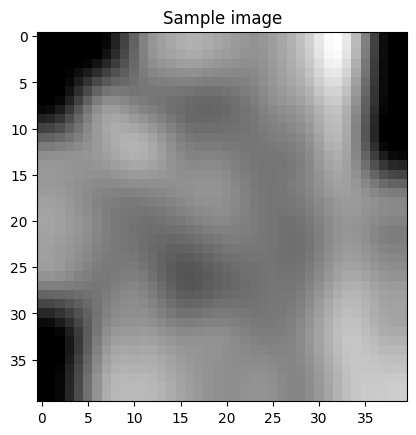

In [8]:
data_dir = './T2ax'
img_paths = glob(os.path.join(data_dir, '*'))

plt.imshow(Image.open(img_paths[0]), 'gray')
plt.title("Sample image")
plt.show()

In [12]:
info_df = pd.DataFrame(img_paths, columns=['img_path'])
info_df.head(5)

,img_path
0,./T2ax/ProstateX-0000_1_T2ax_9_rot-90.png
1,./T2ax/ProstateX-0110_1_T2ax_13_rot-60.png
2,./T2ax/ProstateX-0040_1_T2ax_8_rot-90.png
3,./T2ax/ProstateX-0111_1_T2ax_10_rot-90.png
4,./T2ax/ProstateX-0019_1_T2ax_9_rot50.png


In [15]:
info_df['patientid'] = info_df['img_path'].apply(lambda x : x.split(os.sep)[-1].split('-')[1][:4])
info_df['label'] = info_df['img_path'].apply(lambda x : x.split(os.sep)[-1].split('_')[1])
info_df.head()

,img_path,patientid,label
0,./T2ax/ProstateX-0000_1_T2ax_9_rot-90.png,0000,1
1,./T2ax/ProstateX-0110_1_T2ax_13_rot-60.png,0110,1
2,./T2ax/ProstateX-0040_1_T2ax_8_rot-90.png,0040,1
3,./T2ax/ProstateX-0111_1_T2ax_10_rot-90.png,0111,1
4,./T2ax/ProstateX-0019_1_T2ax_9_rot50.png,0019,1


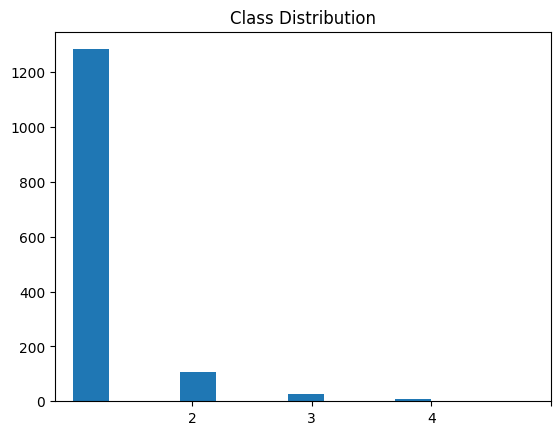

In [16]:
plt.hist(info_df['label'])
plt.title("Class Distribution")
plt.xticks([1., 2., 3., 4.])
plt.show()

In [17]:
def feature_extract(img_path, voxel = (1,1,1), features = ['firstorder', 'glcm', 'glszm', 'glrlm', 'ngtdm', 'shape']):
    '''
    :param image_path: image_array (numpy array)
    :param image_mask: mask_array (numpy array)
    :return: whole features, featureVector
    '''
    image = np.array(Image.open(img_path))[..., None]
    mask = np.ones_like(image)
    mask[0,:,:] = 0
    mask[39,:,:] = 0
    mask[:,0,:] = 0
    mask[:,39,:] = 0

    image = sitk.GetImageFromArray(image)
    mask = sitk.GetImageFromArray(mask)

    settings = {}
    settings['binwidth'] = 5
    settings['resampledPixelSpacing'] = None
    settings['interpolator'] = 'sitkLinear'
    settings['verbose'] = True

    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)
    extractor.settings['enableCExtensions'] = True

    for feature in features:
        extractor.enableFeatureClassByName(feature.lower())

    featureVector = extractor.execute(image, mask)

    cols = []; feats = []
    for feature in features:
        for featureName in sorted(featureVector.keys()):
            if feature in featureName:
                cols.append(featureName)
                feats.append(featureVector[featureName])
    return feats, cols

In [19]:
cnt = 0

for row in tqdm_notebook(info_df.iterrows()):
  img_path = row[1]['img_path']
  feats, cols = feature_extract(img_path)

  row_w_feats = pd.DataFrame(pd.concat([row[1], pd.Series(feats, cols)])).T

  if cnt == 0:
    feat_df = row_w_feats
  else:
    feat_df = pd.concat([feat_df, row_w_feats])

  cnt += 1

  # if cnt == 100:
  #   break

<ipython-input-19-f8840877a44e>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for row in tqdm_notebook(info_df.iterrows()):


0it [00:00, ?it/s]

In [21]:
feat_df.head()

,img_path,patientid,label,original_firstorder_10Percentile,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_InterquartileRange,original_firstorder_Kurtosis,original_firstorder_Maximum,...,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MeshVolume,original_shape_MinorAxisLength,original_shape_Sphericity,original_shape_SurfaceArea,original_shape_SurfaceVolumeRatio,original_shape_VoxelVolume
0,./T2ax/ProstateX-0000_1_T2ax_9_rot-90.png,0000,1,86.0,175.0,26954352.0,2.5525741295922373,36.0,5.214359620329901,254.0,...,38.0,53.03772242470448,38.0,53.03772242470448,1406.1666666666667,43.863424,0.205823661499556,2949.0356580388043,2.0972163029788815,1444.0
0,./T2ax/ProstateX-0110_1_T2ax_13_rot-60.png,0110,1,0.0,129.0,12909096.0,2.3760667361847205,40.0,2.854533827362147,237.0,...,38.0,53.03772242470448,38.0,53.03772242470448,1406.1666666666667,43.863424,0.205823661499556,2949.0356580388043,2.0972163029788815,1444.0
0,./T2ax/ProstateX-0040_1_T2ax_8_rot-90.png,0040,1,39.0,155.0,18105568.0,2.6573286723590193,46.0,3.608650208156215,255.0,...,38.0,53.03772242470448,38.0,53.03772242470448,1406.1666666666667,43.863424,0.205823661499556,2949.0356580388043,2.0972163029788815,1444.0
0,./T2ax/ProstateX-0111_1_T2ax_10_rot-90.png,0111,1,0.0,161.0,20711778.0,2.6471649708944787,52.25,2.7935287824940644,247.0,...,38.0,53.03772242470448,38.0,53.03772242470448,1406.1666666666667,43.863424,0.205823661499556,2949.0356580388043,2.0972163029788815,1444.0
0,./T2ax/ProstateX-0019_1_T2ax_9_rot50.png,0019,1,0.0,157.0,18111701.0,2.588550921488596,51.0,2.527411033466241,255.0,...,38.0,53.03772242470448,38.0,53.03772242470448,1406.1666666666667,43.863424,0.205823661499556,2949.0356580388043,2.0972163029788815,1444.0


In [22]:
# Split Train-Test Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# convert to uint8
y = feat_df['label'].astype(np.uint8)[:]

# set as subset
y  = [0 if i == 1 else 1 for i in y] # important

X = feat_df.drop(['img_path', 'patientid', 'label'], axis=1)[:]

my_scaler = MinMaxScaler().fit(X)
X = my_scaler.transform(X)

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2)
# X.iloc[X_train]

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score,classification_report,confusion_matrix,RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV

In [31]:
params = {
    'n_estimators' : [50, 100],
    'max_depth' : range(5, 41, 5),
    'max_features' : range(5, 80, 5),
    'class_weight' : [{0:0.9, 1:10}, {0:1.1, 1:10}]
}

clf = RandomForestClassifier(random_state=42)
clf = RandomizedSearchCV(clf, params, scoring='roc_auc', n_iter=50)

clf.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_iter=50,
                   param_distributions={'class_weight': [{0: 0.9, 1: 10},
                                                         {0: 1.1, 1: 10}],
                                        'max_depth': range(5, 41, 5),
                                        'max_features': range(5, 80, 5),
                                        'n_estimators': [50, 100]},
                   scoring='roc_auc')

In [34]:
print(clf.best_params_)

y_pred = clf.predict(X_test)

y_pred_prob = clf.predict_proba(X_test)[:, 0]

print(y_pred)
print(y_pred_prob)

{'n_estimators': 50, 'max_features': 5, 'max_depth': 35, 'class_weight': {0: 0.9, 1: 10}}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0.98 1.   0.96 1.   1.   0.94 0.98 0.98 0.9  0.98 1.   1.   0.94 0.98
 1.   1.   0.98 0.94 0.94 1.   0.9  0.46 0.92 1.   1.   0.84 0.98 1.
 0.66 1.   0.98 0.82 0.9  0.96 0.94 0.98 0.66 0.92 0.9  1.   1.   0.92
 0.7  0.58 0.96 1.   1.   1.   1.   1.   0.96 0.9  1.   0.96 0.98 0.78
 1.   0.96 0.78 0.56 0.98 0.86 0.88 0.88 1.   1

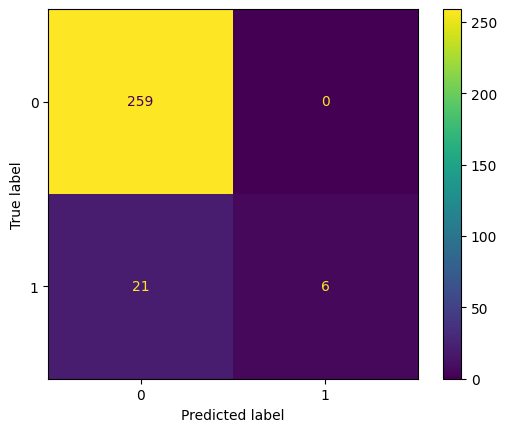

In [35]:
# Confusion matrix
ConfusionMatrixDisplay.from_estimator(clf,X_test,y_test)

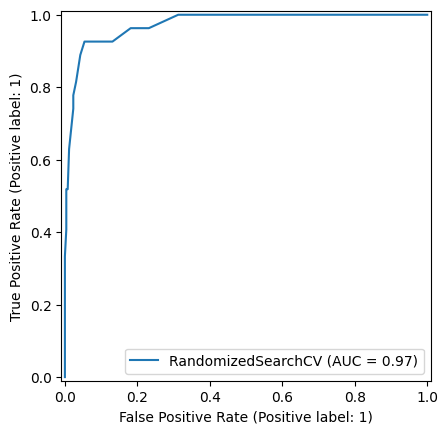

In [36]:
# plot roc curve
rf_roc_curve = RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [37]:
print('Classification Report: \n\n',classification_report(y_test, y_pred, target_names=["Group1","Group2-5"]))

Classification Report: 

               precision    recall  f1-score   support

      Group1       0.93      1.00      0.96       259
    Group2-5       1.00      0.22      0.36        27

    accuracy                           0.93       286
   macro avg       0.96      0.61      0.66       286
weighted avg       0.93      0.93      0.90       286

